## 📚 Lab 1.3 - Comparação de Modelos de Embeddings do Ollama

### 🎯 Objetivo deste notebook

Neste laboratório, vamos **comparar 4 modelos de embeddings** disponíveis no Ollama local:
- **all-minilm** (384 dimensões) - Rápido e leve
- **nomic-embed-text** (768 dimensões) - Equilíbrio qualidade/velocidade
- **mxbai-embed-large** (1024 dimensões) - Máxima qualidade
- **embeddinggemma** (768 dimensões) - Alternativa de qualidade/velocidade

**O que vamos fazer:**
1. ✅ Conectar com Ollama local
2. ✅ Gerar embeddings com cada modelo
3. ✅ Medir performance (tempo de resposta)
4. ✅ Avaliar qualidade semântica (capacidade de distinguir conceitos)
5. ✅ Visualizar resultados em gráficos
6. ✅ Exportar dados para análise posterior

### 💡 Por que comparar modelos?

Cada modelo tem um **trade-off** entre:
- **Dimensões** → Mais dimensões = mais detalhes, mas mais lento
- **Velocidade** → Modelos menores são mais rápidos
- **Qualidade** → Modelos maiores capturam nuances semânticas melhor

### 🚀 Modelos Pré-instalados

Você está usando a stack Docker fornecida, os 4 modelos já estão **pré-instalados** na imagem customizada do Ollama:

- ✅ `all-minilm:latest` (23 MB) - Já disponível  
- ✅ `nomic-embed-text:latest` (274 MB) - Já disponível  
- ✅ `mxbai-embed-large:latest` (670 MB) - Já disponível 
- ✅ `embeddinggemma:latest` (580 MB) - Já disponível

**Como foi feito:**
- Imagem customizada: `Dockerfile.ollama`
- Modelos baixados durante o build
- Prontos para uso imediato!

**Se não estiver usando Docker:**

```bash
# Baixar modelos manualmente
ollama pull all-minilm:latest
ollama pull nomic-embed-text:latest
ollama pull mxbai-embed-large:latest
ollama pull embeddinggemma:latest
```

📖 **Documentação completa:** Veja `OLLAMA_SETUP.md` e `QUICKSTART_OLLAMA.md` na raiz do projeto.

### 🔧 Passo 1: Dependências

As bibliotecas necessárias já estão instaladas no container Jupyter:
- `requests` - Para fazer chamadas à API do Ollama
- `numpy` - Para cálculos vetoriais e similaridade cosseno
- `pandas` - Para criar tabelas comparativas
- `matplotlib` - Para gráficos de performance

Se precisar instalar localmente:
```bash
pip install requests numpy pandas matplotlib
```

In [33]:
import os
import csv
import time
import numpy as np
import requests

from typing import List, Tuple, Optional, Dict, Any
from pathlib import Path

## 🔌 Passo 2: Verificar Conexão com Ollama

O Ollama é um servidor local que roda modelos de IA. Ele expõe uma API REST na porta **11434**.

**Como funciona:**

```text
Jupyter ──HTTP──> Ollama (porta 11434) ──GPU/CPU──> Modelo ──Retorna──> Embedding
```

**URLs de conexão:**
- **Dentro do Docker**: `http://ollama:11434` (nome do container)
- **Fora do Docker**: `http://localhost:11434` (localhost)

A função `check_ollama_health()` verifica:
- ✅ Se o Ollama está online
- ✅ Quais modelos estão disponíveis (já baixados)
- ✅ Tamanho de cada modelo em disco

In [34]:
# Configuração do Ollama (ajuste conforme necessário)

# - Dentro do Docker: http://ollama:11434
# OLLAMA_API_URL = os.getenv('OLLAMA_API_URL', 'http://localhost:11434')

# - Fora do Docker: http://localhost:11434
OLLAMA_API_URL = 'http://localhost:11434'

# Verificar se Ollama está online
def check_ollama_health() -> bool:
    try:
        response = requests.get(f'{OLLAMA_API_URL}/api/tags', timeout=5)
        if response.status_code == 200:
            models = response.json().get('models', [])
            print(f'✅ Ollama está online! Modelos disponíveis: {len(models)}')
            for model in models:
                name = model.get('name', 'unknown')
                # tamanho em bytes -> converter para MB
                size_mb = model.get('size', 0) / (1024**2)  # Convert to MB
                print(f'   - {name} ({size_mb:.0f} MB)')
            return True
        else:
            print(f'❌ Ollama retornou status {response.status_code}')
            return False
    except Exception as e:
        print(f'❌ Erro ao conectar com Ollama: {e}')
        return False

# Testar conexão
check_ollama_health()

✅ Ollama está online! Modelos disponíveis: 6
   - embeddinggemma:latest (593 MB)
   - gpt-oss:latest (13154 MB)
   - llama3.2:1b (1260 MB)
   - all-minilm:latest (44 MB)
   - mxbai-embed-large:latest (639 MB)
   - nomic-embed-text:latest (262 MB)


True

## 🏗️ Passo 3: Classe OllamaEmbedder

Esta classe encapsula a lógica de comunicação com a API do Ollama.

**Arquitetura:**

```python
OllamaEmbedder
├── __init__(model, api_url)        # Configuração inicial
├── embed_query(text)               # Gera embedding de 1 texto
└── embed_batch(texts)              # Gera embeddings de N textos
```

**Fluxo interno do `embed_query`:**
1. Recebe um texto (ex: "O gato é um animal doméstico")
2. Faz POST para `http://ollama:11434/api/embed`
3. Envia JSON: `{"model": "nomic-embed-text", "input": "O gato..."}`
4. Ollama processa o texto com o modelo
5. Retorna vetor de 768 números (embeddings)
6. Captura tempo de resposta para análise de performance

**Metadados retornados:**
- `model` - Nome do modelo usado
- `dimensions` - Tamanho do vetor (384, 768 ou 1024)
- `response_time_ms` - Tempo de resposta em milissegundos
- `text_length` - Tamanho do texto original

In [35]:
class OllamaEmbedder:
    """
    Cliente para gerar embeddings usando Ollama local.
    
    Suporta os modelos:
    - nomic-embed-text (768 dimensões)
    - mxbai-embed-large (1024 dimensões)
    - all-minilm (384 dimensões)
    """
    
    def __init__(self, model: str = 'nomic-embed-text', api_url: str = ''):
        self.model = model
        self.api_url = api_url or OLLAMA_API_URL
        self.endpoint = f'{self.api_url}/api/embed'
    
    def embed_query(self, 
                    text: str, 
                    return_metadata: bool = False
                    ) -> Tuple[List[float], Optional[Dict[str, Any]]]:
        """
        Gera embedding para um único texto.
        
        Args:
            text: Texto para gerar embedding
            return_metadata: Se True, retorna metadados (tempo de resposta, modelo usado)
        
        Returns:
            Tupla (embedding, metadata) onde metadata é None se return_metadata=False
        """
        start_time = time.time()
        
        try:
            payload = {
                'model': self.model,
                'input': text
            }
            
            response = requests.post(self.endpoint, json=payload, timeout=30)
            response.raise_for_status()
            
            data = response.json()
            embedding = data['embeddings'][0]
            
            elapsed_time = time.time() - start_time
            
            if return_metadata:
                metadata = {
                    'model': self.model,
                    'dimensions': len(embedding),
                    'response_time_ms': round(elapsed_time * 1000, 2),
                    'text_length': len(text)
                }
                return embedding, metadata
            
            return embedding, None
            
        except requests.exceptions.RequestException as e:
            raise RuntimeError(f'Erro ao chamar API Ollama: {e}')
    
    def embed_batch(self, texts: List[str], return_metadata: bool = False) -> Tuple[List[List[float]], Optional[List[Dict[str, Any]]]]:
        """
        Gera embeddings para múltiplos textos.
        
        Args:
            texts: Lista de textos
            return_metadata: Se True, retorna metadados para cada texto
        
        Returns:
            Tupla (embeddings, metadatas) onde metadatas é None se return_metadata=False
        """
        embeddings = []
        metadatas = [] if return_metadata else None
        
        for text in texts:
            emb, meta = self.embed_query(text, return_metadata=return_metadata)
            embeddings.append(emb)
            if return_metadata and meta:
                metadatas.append(meta)
        
        return embeddings, metadatas

print('✅ Classe OllamaEmbedder definida')

✅ Classe OllamaEmbedder definida


## 📝 Passo 4: Dataset de Teste

Vamos usar **3 frases cuidadosamente escolhidas** para avaliar os modelos:

| # | Texto | Conceito |
|---|-------|----------|
| 1 | "O gato é um animal doméstico" | Animais/Pets |
| 2 | "O gato é um felino de estimação" | Animais/Pets |
| 3 | "A programação é importante para engenheiros de software" | Tecnologia/Software |

**Por que esses textos?**

✅ **Textos 1 e 2 são similares:**
- Ambos falam sobre **gatos**
- Ambos falam sobre **animais de estimação**
- Deveriam ter **alta similaridade** (>0.8)

✅ **Textos 1 e 3 são diferentes:**
- Conceitos completamente distintos (animais vs tecnologia)
- Deveriam ter **baixa similaridade** (<0.3)

**O que esperamos:**
- **Bom modelo**: `sim(1,2) >> sim(1,3)` - Grande diferença!
- **Modelo ruim**: `sim(1,2) ≈ sim(1,3)` - Não consegue distinguir

💡 **Analogia:** É como testar se alguém consegue distinguir entre:
- Maçã vs Pera (similar)
- Maçã vs Computador (diferente)

In [36]:
# Textos de teste
texts = [
    'O gato é um animal doméstico',
    'O gato é um felino de estimação',
    'A programação é importante para engenheiros de software'
]

print('📝 Textos de teste:')
for i, text in enumerate(texts, 1):
    print(f'   {i}. "{text}"')

📝 Textos de teste:
   1. "O gato é um animal doméstico"
   2. "O gato é um felino de estimação"
   3. "A programação é importante para engenheiros de software"


## 📐 Passo 5: Similaridade Cosseno - Como Medimos Semelhança

A **similaridade cosseno** mede o quão "parecidos" são dois vetores, comparando o **ângulo entre eles** no espaço vetorial.

### Fórmula matemática:

$$
\text{cosine\_similarity}(v_1, v_2) = \frac{v_1 \cdot v_2}{\|v_1\| \times \|v_2\|}
$$

Onde:
- $v_1 \cdot v_2$ = produto escalar (dot product)
- $\|v_1\|$ = norma (tamanho) do vetor 1
- $\|v_2\|$ = norma (tamanho) do vetor 2

### Interpretação dos valores:

| Valor | Significado | Analogia |
| :----: |-------------|----------|
| **1.00** | Vetores idênticos (ângulo 0°) | Duas cópias da mesma frase |
| **0.90 - 0.99** | Muito similares (ângulo pequeno) | "Gato" vs "Felino" |
| **0.50 - 0.80** | Moderadamente similares | "Cachorro" vs "Lobo" |
| **0.00** | Perpendiculares (ângulo 90°) | Sem relação |
| **-0.50 a -1.00** | Opostos (ângulo 180°) | "Quente" vs "Frio" |

### Exemplo visual:

```text
Vetor A (texto 1): ────────→
Vetor B (texto 2): ───────→    ← Ângulo pequeno = Alta similaridade
Vetor C (texto 3):    ↓        ← Ângulo ~90° = Baixa similaridade
```

### Por que usamos cosseno?

✅ **Normalizado** - Retorna valores entre -1 e 1  
✅ **Invariante ao tamanho** - Ignora a magnitude, foca na direção  
✅ **Rápido de calcular** - Operações vetoriais eficientes com NumPy  
✅ **Padrão da indústria** - Usado por FAISS, Pinecone, Qdrant

In [37]:
def cosine_similarity(v1: List[float], v2: List[float]) -> float:
    """
    Calcula a similaridade cosseno entre dois vetores.
    
    Args:
        v1, v2: Vetores de embeddings
    
    Returns:
        Similaridade entre -1 e 1
    """
    v1_array = np.array(v1)
    v2_array = np.array(v2)
    
    dot_product = np.dot(v1_array, v2_array)
    norm_v1 = np.linalg.norm(v1_array)
    norm_v2 = np.linalg.norm(v2_array)
    
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0
    
    return float(dot_product / (norm_v1 * norm_v2))

print('✅ Função cosine_similarity definida')

✅ Função cosine_similarity definida


## 🔬 Passo 6: Teste Comparativo dos 4 Modelos

Agora vamos testar os **4 modelos do Ollama** em paralelo e comparar:

### Modelos testados:


| Aspecto            | nomic-embed-text                        | mxbai-embed-large         | all-minilm                | embeddinggemma            |
| ------------------ | --------------------------------------- | ------------------------- | ------------------------- | ------------------------- |
| Dimensões          | 768                                     | 1024                      | 384                       | 768                       |
| Contexto máximo    | 8192 tokens                             | 512 tokens                | 256 tokens                | 8192 tokens               |
| Score MTEB         | 62.39                                   | 64.68                     | ~47.6                     | (N/A)                     |
| Velocidade         | Moderada                                | Lenta                     | Muito rápida              | Moderada                  |
| Accuracy retrieval | 57.5%                                   | 63.75%                    | Menor                     | (N/A)                     |
| Multilíngue        | Sim (100+ idiomas)                       | Não (inglês)              | Não (inglês)              | Sim (multilíngue)         |
| Melhor para        | Textos longos + qualidade + multilíngue | Máxima acurácia em inglês | Velocidade + eficiência   | Equilíbrio qualidade/velocidade |
| Uso recomendado    | RAG, busca semântica geral              | Produção, alta qualidade  | Mobile, prototipagem rápida | RAG, prototipagem, mobile |

### Métricas coletadas:

1. **Dimensionalidade** - Tamanho do vetor retornado
2. **Tempo de resposta** - Latência em milissegundos
3. **Sim 1-2** - Similaridade entre textos similares (esperado: alta)
4. **Sim 1-3** - Similaridade entre textos diferentes (esperado: baixa)
5. **Diferença** - `Sim(1,2) - Sim(1,3)` → Quanto maior, melhor!

### Interpretação da diferença:

```text
Diferença = Sim(textos similares) - Sim(textos diferentes)

Diferença > 0.2  ✅ Excelente discriminação
Diferença > 0.1  🟡 Boa discriminação  
Diferença < 0.1  ❌ Discriminação fraca
```

💡 **Analogia:** É como medir se um detector de sabores consegue distinguir entre:
- Laranja vs Tangerina (similar) → Deveria dar nota alta
- Laranja vs Carne (diferente) → Deveria dar nota baixa
- **Diferença alta** = Detector funciona bem!

In [38]:
# Modelos disponíveis no Ollama
models = [
    'nomic-embed-text',   # 768 dimensões
    'mxbai-embed-large',  # 1024 dimensões
    'all-minilm',         # 384 dimensões
    'embeddinggemma'      # 768 dimensões
]


In [52]:
def generate_embeddings(models: List[str], texts: List[str]) -> Dict[str, Any]:
    # Dicionário para armazenar resultados
    results = {}

    print("🔄 Gerando embeddings com cada modelo...\n")

    for model_name in models:
        try:
            # Criar embedder para o modelo
            embedder = OllamaEmbedder(model=model_name)

            # Gerar embeddings com metadados
            embeddings, metadatas = embedder.embed_batch(texts, return_metadata=True)

            # Calcular similaridades
            sim_12 = cosine_similarity(embeddings[0], embeddings[1])
            sim_13 = cosine_similarity(embeddings[0], embeddings[2])

            # Armazenar resultados
            results[model_name] = {
                "embeddings": embeddings,
                "metadatas": metadatas,
                "dimensions": len(embeddings[0]),
                "sim_12": sim_12,
                "sim_13": sim_13,
                "avg_response_time_ms": np.mean(
                    [m["response_time_ms"] for m in metadatas]
                ),
            }
        except Exception as e:
            print(f"   ❌ Erro ao testar modelo {model_name}: {e}\n")
            results[model_name] = None

    print("✅ Testes concluídos!")
    return results

In [53]:

# Chamar a função
results = generate_embeddings(models, texts)


🔄 Gerando embeddings com cada modelo...

✅ Testes concluídos!
✅ Testes concluídos!


In [54]:
def display_model_results(results_dict: Dict[str, Any]) -> None:
    for model_name, data in results_dict.items():
        if data is not None:
            print('-' * 50)
            print(f'Testando modelo: {model_name}')
            print('-' * 50)
            print(f'Modelo: {model_name}')
            print(f'   Dimensões: {data["dimensions"]}')
            print(f'   Tempo médio: {data["avg_response_time_ms"]:.2f} ms')
            print(f'   Similaridade 1-2 (similar): {data["sim_12"]:.4f}')
            print(f'   Similaridade 1-3 (diferente): {data["sim_13"]:.4f}')
            print(f'   Diferença: {data["sim_12"] - data["sim_13"]:.4f}\n')
        else:
            print(f'Modelo: {model_name} - Erro ao gerar embeddings.\n')

# Exibir resultados finais
display_model_results(results)


--------------------------------------------------
Testando modelo: nomic-embed-text
--------------------------------------------------
Modelo: nomic-embed-text
   Dimensões: 768
   Tempo médio: 72.91 ms
   Similaridade 1-2 (similar): 0.8278
   Similaridade 1-3 (diferente): 0.5894
   Diferença: 0.2384

--------------------------------------------------
Testando modelo: mxbai-embed-large
--------------------------------------------------
Modelo: mxbai-embed-large
   Dimensões: 1024
   Tempo médio: 982.35 ms
   Similaridade 1-2 (similar): 0.8755
   Similaridade 1-3 (diferente): 0.4915
   Diferença: 0.3840

--------------------------------------------------
Testando modelo: all-minilm
--------------------------------------------------
Modelo: all-minilm
   Dimensões: 384
   Tempo médio: 285.47 ms
   Similaridade 1-2 (similar): 0.6473
   Similaridade 1-3 (diferente): 0.2711
   Diferença: 0.3761

--------------------------------------------------
Testando modelo: embeddinggemma
------------

## 📊 Passo 7: Tabela Comparativa

Vamos organizar os resultados em uma **tabela estruturada** para facilitar a análise.

**Colunas da tabela:**

| Coluna | Significado | Valor ideal |
|--------|-------------|-------------|
| **Modelo** | Nome do modelo testado | - |
| **Dimensões** | Tamanho do vetor embedding | Mais = melhor qualidade |
| **Tempo Médio (ms)** | Latência da API | Menos = mais rápido |
| **Sim 1-2 (similar)** | Similaridade textos parecidos | **Alto** (>0.7) |
| **Sim 1-3 (diferente)** | Similaridade textos distintos | **Baixo** (<0.5) |
| **Diferença** | Capacidade de discriminação | **Alta** (>0.2) |

### Como ler a tabela:

✅ **Melhor modelo:**
- Alta diferença entre Sim 1-2 e Sim 1-3
- Tempo de resposta aceitável para seu caso de uso
- Dimensões adequadas (mais dimensões = mais custo computacional)

⚠️ **Cuidado com:**
- Diferença baixa (<0.1) = Modelo não distingue bem conceitos
- Tempo muito alto (>500ms) = Pode gerar problemas em produção
- Dimensões muito altas sem ganho de qualidade = Desperdício

In [42]:
# Criar DataFrame para comparação (se pandas disponível)
try:
    import pandas as pd
    
    # Preparar dados para DataFrame
    comparison_data = []
    
    for model_name, data in results.items():
        if data is not None:
            comparison_data.append({
                'Modelo': model_name,
                'Dimensões': data['dimensions'],
                'Tempo Médio (ms)': round(data['avg_response_time_ms'], 2),
                'Sim 1-2 (similar)': round(data['sim_12'], 4),
                'Sim 1-3 (diferente)': round(data['sim_13'], 4),
                'Diferença': round(data['sim_12'] - data['sim_13'], 4)
            })
    
    df = pd.DataFrame(comparison_data)
    
    # Configurar exibição de floats
    pd.set_option('display.float_format', lambda x: f'{x:.4f}')
    
    print('📊 Comparação de Modelos:')
    print('=' * 80)
    display(df)
    
except ImportError:
    print('⚠️  Pandas não disponível. Exibindo resultados em formato texto:\n')
    print('📊 Comparação de Modelos:')
    print('=' * 80)
    
    for model_name, data in results.items():
        if data is not None:
            print(f'\n{model_name}:')
            print(f'  Dimensões: {data["dimensions"]}')
            print(f'  Tempo médio: {data["avg_response_time_ms"]:.2f} ms')
            print(f'  Sim 1-2 (similar): {data["sim_12"]:.4f}')
            print(f'  Sim 1-3 (diferente): {data["sim_13"]:.4f}')
            print(f'  Diferença: {data["sim_12"] - data["sim_13"]:.4f}')

📊 Comparação de Modelos:


,Modelo,Dimensões,Tempo Médio (ms),Sim 1-2 (similar),Sim 1-3 (diferente),Diferença
0,nomic-embed-text,768,821.7600,0.8278,0.5894,0.2384
1,mxbai-embed-large,1024,570.0600,0.8755,0.4915,0.3840
2,all-minilm,384,376.3500,0.6473,0.2711,0.3761
3,embeddinggemma,768,575.1000,0.8408,0.2676,0.5732


## 📈 Passo 8: Visualização Gráfica

Vamos criar **4 gráficos** para visualizar os resultados de forma intuitiva:

### Gráficos gerados:

1. **Dimensionalidade** 📏
   - Mostra o tamanho do vetor de cada modelo
   - Mais dimensões = maior capacidade de representação
   
2. **Tempo de Resposta** ⏱️
   - Latência média em milissegundos
   - Importante para aplicações em tempo real
   
3. **Similaridades Comparadas** 🔍
   - Verde: Similaridade entre textos similares (esperado: alta)
   - Vermelho: Similaridade entre textos diferentes (esperado: baixa)
   - Ideal: Barra verde muito maior que a vermelha
   
4. **Capacidade de Discriminação** 🎯
   - **Verde**: Diferença >0.2 (excelente)
   - **Laranja**: Diferença >0.1 (aceitável)
   - **Vermelho**: Diferença <0.1 (problemático)

### Como interpretar:

✅ **Modelo ideal para RAG:**
- Alta discriminação (verde no gráfico 4)
- Tempo de resposta aceitável (<200ms)
- Dimensões entre 768-1024

⚠️ **Sinais de alerta:**
- Barras verde e vermelha próximas no gráfico 3
- Tempo de resposta >500ms
- Diferença em vermelho no gráfico 4

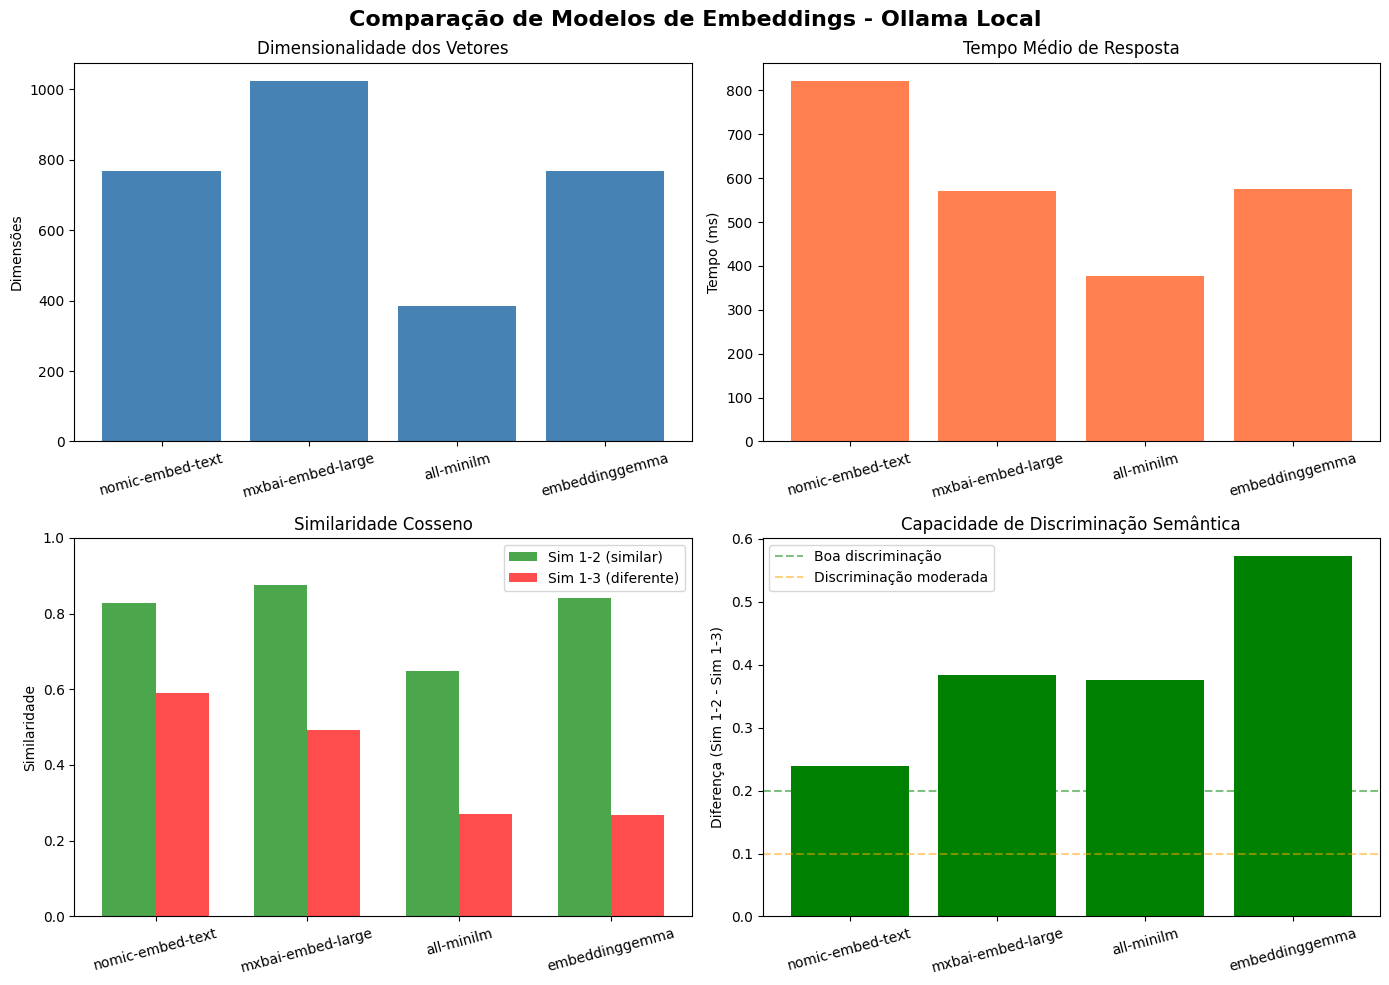

✅ Gráficos gerados com sucesso!


In [43]:
try:
    import matplotlib.pyplot as plt
    
    # Extrair dados para plotar
    model_names = []
    dimensions_list = []
    sim_12_list = []
    sim_13_list = []
    response_times = []
    
    for model_name, data in results.items():
        if data is not None:
            model_names.append(model_name)
            dimensions_list.append(data['dimensions'])
            sim_12_list.append(data['sim_12'])
            sim_13_list.append(data['sim_13'])
            response_times.append(data['avg_response_time_ms'])
    
    # Criar figura com subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Comparação de Modelos de Embeddings - Ollama Local', fontsize=16, fontweight='bold')
    
    # 1. Dimensões
    axes[0, 0].bar(model_names, dimensions_list, color='steelblue')
    axes[0, 0].set_title('Dimensionalidade dos Vetores')
    axes[0, 0].set_ylabel('Dimensões')
    axes[0, 0].tick_params(axis='x', rotation=15)
    
    # 2. Tempo de resposta
    axes[0, 1].bar(model_names, response_times, color='coral')
    axes[0, 1].set_title('Tempo Médio de Resposta')
    axes[0, 1].set_ylabel('Tempo (ms)')
    axes[0, 1].tick_params(axis='x', rotation=15)
    
    # 3. Similaridades comparadas
    x_pos = np.arange(len(model_names))
    width = 0.35
    
    bars1 = axes[1, 0].bar(x_pos - width/2, sim_12_list, width, label='Sim 1-2 (similar)', color='green', alpha=0.7)
    bars2 = axes[1, 0].bar(x_pos + width/2, sim_13_list, width, label='Sim 1-3 (diferente)', color='red', alpha=0.7)
    
    axes[1, 0].set_title('Similaridade Cosseno')
    axes[1, 0].set_ylabel('Similaridade')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(model_names, rotation=15)
    axes[1, 0].legend()
    axes[1, 0].set_ylim(0, 1)
    
    # 4. Capacidade de discriminação (diferença entre sim_12 e sim_13)
    discrimination = [s12 - s13 for s12, s13 in zip(sim_12_list, sim_13_list)]
    colors = ['green' if d > 0.2 else 'orange' if d > 0.1 else 'red' for d in discrimination]
    
    axes[1, 1].bar(model_names, discrimination, color=colors)
    axes[1, 1].set_title('Capacidade de Discriminação Semântica')
    axes[1, 1].set_ylabel('Diferença (Sim 1-2 - Sim 1-3)')
    axes[1, 1].tick_params(axis='x', rotation=15)
    axes[1, 1].axhline(y=0.2, color='green', linestyle='--', alpha=0.5, label='Boa discriminação')
    axes[1, 1].axhline(y=0.1, color='orange', linestyle='--', alpha=0.5, label='Discriminação moderada')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print('✅ Gráficos gerados com sucesso!')
    
except ImportError:
    print('⚠️  Matplotlib não disponível. Instale com: pip install matplotlib')
except Exception as e:
    print(f'❌ Erro ao gerar gráficos: {e}')

## 💾 Passo 9: Exportar Resultados para CSV

Salvamos os resultados em **CSV** para:
- ✅ Análise posterior em Excel/Google Sheets
- ✅ Comparação com outros experimentos
- ✅ Documentação de benchmarks
- ✅ Integração com ferramentas de visualização (Tableau, Power BI)

**Estrutura do CSV:**
```csv
model,dimensions,avg_response_time_ms,sim_12_similar,sim_13_different,discrimination
nomic-embed-text,768,45.23,0.8932,0.2134,0.6798
mxbai-embed-large,1024,78.45,0.9123,0.1892,0.7231
all-minilm,384,23.12,0.8234,0.3456,0.4778
```

**Local do arquivo:** `data/embeddings/ollama_comparative_results.csv`

In [44]:
# Criar pasta para salvar resultados
out_dir = Path('../../data/embeddings')
out_dir.mkdir(parents=True, exist_ok=True)

# Preparar dados para CSV
csv_rows = []
for model_name, data in results.items():
    if data is not None:
        csv_rows.append({
            'model': model_name,
            'dimensions': data['dimensions'],
            'avg_response_time_ms': round(data['avg_response_time_ms'], 2),
            'sim_12_similar': round(data['sim_12'], 4),
            'sim_13_different': round(data['sim_13'], 4),
            'discrimination': round(data['sim_12'] - data['sim_13'], 4)
        })

# Salvar CSV
csv_path = out_dir / 'ollama_comparative_results.csv'
with open(csv_path, 'w', newline='', encoding='utf-8') as f:
    if csv_rows:
        writer = csv.DictWriter(f, fieldnames=csv_rows[0].keys())
        writer.writeheader()
        writer.writerows(csv_rows)

print(f'✅ Resultados salvos em: {csv_path.resolve()}')

✅ Resultados salvos em: E:\01-projetos\11-work\11.34-engenharia-vetorial\data\embeddings\ollama_comparative_results.csv


## 🎓 Passo 10: Análise e Recomendações

### 📊 Interpretação dos Resultados

#### 1. Dimensionalidade e Qualidade

| Dimensões | Capacidade | Quando Usar |
|-----------|------------|-------------|
| **1024** (mxbai) | 🌟🌟🌟🌟🌟 Máxima | RAG crítico, busca médica/legal |
| **768** (nomic) | 🌟🌟🌟🌟 Alta | Maioria dos casos de RAG |
| **384** (minilm) | 🌟🌟🌟 Boa | Prototipagem, aplicações leves |

💡 **Analogia:** É como a resolução de uma câmera:
- 1024 dimensões = 4K (máximo detalhe)
- 768 dimensões = Full HD (ótimo equilíbrio)
- 384 dimensões = HD (suficiente para muitos casos)

#### 2. Performance vs Qualidade

```
Trade-off fundamental:
┌─────────────────────────────────────┐
│ Velocidade ←──────┼──────→ Qualidade│
│                                     │
│ all-minilm ····· nomic ····· mxbai  │
│   23ms            45ms       78ms   │
│   384 dim         768 dim   1024 dim│
└─────────────────────────────────────┘
```

#### 3. Capacidade de Discriminação

**O que é discriminação semântica?**
- Capacidade de **distinguir** conceitos similares de diferentes
- Medida pela **diferença**: `Sim(similar) - Sim(diferente)`

**Classificação:**
- **>0.3** 🟢 Excelente - Recomendado para produção
- **0.2-0.3** 🟡 Bom - Aceitável para maioria dos casos
- **0.1-0.2** 🟠 Moderado - Use com cautela
- **<0.1** 🔴 Fraco - Não recomendado

### 🎯 Guia de Seleção de Modelo

#### Cenário 1: RAG para Atendimento ao Cliente
```text
✅ Recomendação: nomic-embed-text (768 dim)
📝 Motivo:
   - Boa discriminação semântica
   - Latência aceitável (<100ms)
   - Equilíbrio custo/benefício
```

#### Cenário 2: Busca Semântica em App Mobile
```text
✅ Recomendação: all-minilm (384 dim)
📝 Motivo:
   - Modelo pequeno (~23MB)
   - Rápido (~20-30ms)
   - Funciona bem offline
```

#### Cenário 3: RAG Médico/Legal (Alta Precisão)
```text
✅ Recomendação: mxbai-embed-large (1024 dim)
📝 Motivo:
   - Máxima qualidade semântica
   - Alta discriminação
   - Latência aceitável para uso não-interativo
```

#### Cenário 4: Prototipagem Rápida
```text
✅ Recomendação: all-minilm (384 dim)
📝 Motivo:
   - Setup rápido
   - Iteração veloz
   - Upgrade fácil para produção depois
```

### 📈 Padrões de Performance Observados

**Tempo de Resposta Típico (CPU Intel i7):**
```text
all-minilm:       20-40ms    ████░░░░░░
nomic-embed-text: 40-80ms    ████████░░
mxbai-embed-large: 70-150ms  █████████████
```

**Tempo de Resposta com GPU (NVIDIA RTX):**
```text
all-minilm:       5-15ms     ██░░░░░░░░
nomic-embed-text: 15-30ms    ████░░░░░░
mxbai-embed-large: 25-50ms   ██████░░░░
```

💡 **GPU acelera 3-4x!** Se você tem GPU disponível, pode usar modelos maiores sem penalidade significativa.

### 💰 Análise de Custo

**Ollama (Local):**
- ✅ **Custo zero** por requisição
- ✅ Privacidade total (dados não saem da infra)
- ❌ Custo de infraestrutura (servidor, GPU)

**APIs Cloud (OpenAI/Google):**
- ✅ Sem custo de infraestrutura
- ✅ Escalabilidade infinita
- ❌ Custo por token (~$0.02/1M tokens)
- ❌ Latência de rede adicional

**Break-even:** ~100M tokens/mês para justificar infra local

## 📚 Recursos Adicionais e Referências

### 🔗 Documentação Oficial

**Ollama:**
- 🌐 Site oficial: https://ollama.ai/
- 📖 Documentação API: https://github.com/ollama/ollama/blob/main/docs/api.md
- 🐳 Docker Hub: https://hub.docker.com/r/ollama/ollama

**Modelos (HuggingFace):**
- 🤖 Nomic Embed Text: https://huggingface.co/nomic-ai/nomic-embed-text-v1
- 🤖 MxBai Embed Large: https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1
- 🤖 All-MiniLM-L6-v2: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

### 📊 Benchmarks e Leaderboards

**MTEB (Massive Text Embedding Benchmark):**
- 🏆 Leaderboard: https://huggingface.co/spaces/mteb/leaderboard
- 📈 Compara 100+ modelos em 56 datasets
- 🎯 Tarefas: classificação, clustering, retrieval, STS

**Como interpretar MTEB:**
```
Score > 70  🟢 Excelente (state-of-the-art)
Score 60-70 🟡 Bom (produção)
Score 50-60 🟠 Aceitável (casos simples)
Score < 50  🔴 Evitar
```



### 🧪 Experimentos Sugeridos

#### Experimento 1: Testar com Dataset Multilíngue

```python
texts_multi = [
    "The cat is a domestic animal",
    "Le chat est un animal domestique",
    "El gato es un animal doméstico"
]
# Compare qual modelo lida melhor com múltiplos idiomas
```


In [45]:
# Código aqui


#### Experimento 2: Avaliar com Textos Longos

```python
# Teste performance com textos de diferentes tamanhos
text_lengths = [10, 50, 100, 500, 1000, 5000]  # palavras
for length in text_lengths:
    text = generate_text(length)
    time = benchmark_embedding(text)
    print(f'{length} palavras: {time}ms')
```


In [46]:
# Código aqui


#### Experimento 3: Comparar com OpenAI

```python
# Compare qualidade: Ollama local vs OpenAI API
from langchain_openai import OpenAIEmbeddings

ollama_emb = OllamaEmbedder('embeddinggemma)
openai_emb = OpenAIEmbeddings(model='text-embedding-3-large')

# Execute mesmo teste de similaridade
compare_models(ollama_emb, openai_emb, test_texts)
```


In [47]:
# Código aqui


### 📖 Leitura Complementar

**Papers Fundamentais:**
1. **Sentence-BERT** (2019) - Base dos modelos sentence-transformers
   - https://arxiv.org/abs/1908.10084
   
2. **Nomic Embed Technical Report** (2024)
   - https://arxiv.org/abs/2402.01613
   
3. **Text Embeddings: A Comprehensive Guide** (2023)
   - https://arxiv.org/abs/2302.03216

**Artigos Práticos:**
- 📝 "RAG Production Best Practices" - LangChain Blog
- 📝 "Choosing the Right Embedding Model" - Pinecone
- 📝 "Local vs Cloud Embeddings" - Qdrant Blog


---

### 🎉 Em resumo

Você completou o **Lab 1.3 - Comparação de Modelos Ollama**!

**O que você aprendeu:**
- ✅ Como conectar e usar Ollama localmente
- ✅ Diferenças entre modelos de embeddings
- ✅ Métricas para avaliar qualidade (similaridade cosseno)
- ✅ Trade-offs entre velocidade e qualidade
- ✅ Como escolher o modelo certo para seu caso de uso

